# Monitoring Changes in Surface Water Using Satellite Image Data 

## Set-up data pipeline

<table style="font-size: 1em; padding: 0; margin: 0;">
<p style="border: 1px solid #ff5733; border-left: 15px solid #ff5733; padding: 10px; text-align:justify;">
    <strong style="color: #ff5733">Deliverable</strong>  
    <br/>The deliverable for Part 2 is a jupyter notebook showing a workflow to create test and training datasets, consisting of folders of imagery and corresponding label imagery, ready for training a semantic segmentation model in keras. This will mostly test your understanding the generic workflow for preparing a dataset to train and test a deep learning model, which is an essential component of the remaining Parts.
    </p>

### Python packages importation

In [32]:
import shutil, os
import glob
import json

import matplotlib
from matplotlib import pyplot as plt
# In order to avoid DecompressionBombError
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import numpy as np

import rasterio
print("rasterio version",rasterio.__version__)
import tensorflow as tf
print("TensorFlow version",tf.__version__)


rasterio version 0.36.0
TensorFlow version 2.0.0


### Directories and data folder set-up


In [33]:
## create directories to move the images and labels into. 
## It is wrapped in a "try:except" loop 
## in case you have run this cell before and want to avoid errors
try:
    os.mkdir('training_images')
    os.mkdir('training_labels')
    os.mkdir('validation_images')
    os.mkdir('validation_labels')
    os.mkdir('testing_images')
    os.mkdir('testing_labels')
except:
    pass

print("Code executed")


Code executed


### Data acquisition

##### Download the dataset from google drive. 

Warning, this will download 415 MB. We saw this function for downloading a file in the previous Part

In [34]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

import zipfile

def unzip_nwpu(f):
    """
    f = file to be unzipped
    """    
    with zipfile.ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall()
print("Code loaded")


Code loaded


Download the google drive file into a zipped folder on your computer called `NWPU_images.zip`. This should be 405 MB

In [35]:
file_id = '14kkcuU6wd9UMvjaDrg3PNI-e_voCi8HL'
destination = 'NWPU_images.zip'
download_file_from_google_drive(file_id, destination)
print("Code executed")


Code executed


Unzip the folder (this may take a few minutes) as a new folder called images

In [36]:
unzip_nwpu(destination)
print("Code executed")


Code executed


Rename the `images` directory

In [37]:
import shutil, os

try:
    os.rename('images','nwpu_images')
except:
    pass

print("Code executed")


Code executed


Remove non-lake directories that we won't need. First find all subdirectories (except the first, which is the parent directory)

In [38]:
subdirecs = [x[0] for x in os.walk('nwpu_images')][1:]
to_delete = [s for s in subdirecs if 'lake' not in s]
for k in to_delete:
    shutil.rmtree(k, ignore_errors=True) 
print("Code executed")


Code executed


### Create a label image or 'mask' from label polygons 

In [82]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# In order to avoid DecompressionBombError
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import rasterio

def get_image_coordinates(data):
    X = []; Y = [] #pre-allocate lists to fill in a for loop
    for k in data['regions']: #cycle through each polygon
        # get the x and y points from the dictionary
        X.append(data['regions'][k]['shape_attributes']['all_points_x'])
        Y.append(data['regions'][k]['shape_attributes']['all_points_y'])
    return Y,X #image coordinates are flipped relative to json coordinates

# Alternative implementation suggested by Ambreen
def create_mask_label_image(image,X,Y):
    nx, ny = np.shape(image)
    mask = np.zeros((ny, nx))
    for x,y in zip(X,Y):
        polygon = np.vstack((x, y)).reshape((-1,),order='F').tolist()
        img = Image.new('L', (nx, ny), 0)
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        m = np.array(img)
        mask = mask + m
    return mask.T

print("Code loaded")


Code loaded


### Test

Polygon coordinates:
 [[33.10344827586207, 24.82758620689655, 24.82758620689655, 34.758620689655174, 50.206896551724135, 79.44827586206897, 106.48275862068965, 129.6551724137931, 157.79310344827587, 174.89655172413794, 190.89655172413794, 198.06896551724137, 205.79310344827587, 206.3448275862069, 200.82758620689654, 187.0344827586207, 160, 138.48275862068965, 123.03448275862068, 112.55172413793103, 102.06896551724138, 92.6896551724138, 69.51724137931035, 52.41379310344828, 39.724137931034484, 33.10344827586207], [0.5517241379310345, 11.03448275862069, 37.51724137931034, 54.62068965517241, 56.275862068965516, 53.51724137931034, 48.55172413793103, 44.689655172413794, 0, 0, 0.5517241379310345], [79.44827586206897, 107.03448275862068, 125.79310344827586, 146.75862068965517, 172.13793103448276, 190.89655172413794, 196.9655172413793, 202.48275862068965, 205.24137931034483, 209.10344827586206, 209.10344827586206, 80, 79.44827586206897]] [[101.51724137931035, 115.86206896551724, 131.8620689655

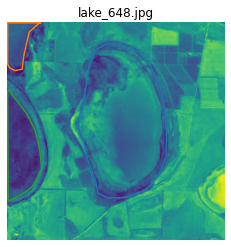

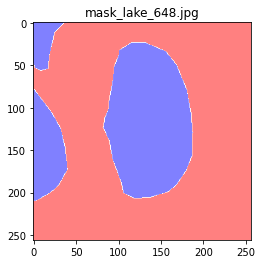

In [84]:
data_dir = "/home/user/Documents/ImgSatCNN-Project/Buscombe_liveProject_Feb2020/SatImgCNN-Deliverables"
data_dir_images = data_dir + os.sep + "nwpu_images" + os.sep + "lake"
lake_id = 'lake_648.jpg'

with rasterio.open(data_dir_images+os.sep+lake_id) as image_file:
    image = image_file.read(1)

json_data = {"fileref": "", 
             "size": 11085, 
             "filename": "lake_648.jpg", 
             "base64_img_data": "", 
             "file_attributes": {}, 
             "regions": {"0": {"shape_attributes": {"name": "polygon", 
                                                    "all_points_x": [101.51724137931035, 115.86206896551724, 131.86206896551724, 155.0344827586207, 168.27586206896552, 180.9655172413793, 185.3793103448276, 187.0344827586207, 186.48275862068965, 179.86206896551724, 168.82758620689654, 159.44827586206895, 137.3793103448276, 118.06896551724138, 106.48275862068965, 103.72413793103448, 93.79310344827586, 89.37931034482759, 82.20689655172414, 84.9655172413793, 88.27586206896552, 89.37931034482759, 93.24137931034483, 95.44827586206897, 100.41379310344827, 101.51724137931035], 
                                                    "all_points_y": [33.10344827586207, 24.82758620689655, 24.82758620689655, 34.758620689655174, 50.206896551724135, 79.44827586206897, 106.48275862068965, 129.6551724137931, 157.79310344827587, 174.89655172413794, 190.89655172413794, 198.06896551724137, 205.79310344827587, 206.3448275862069, 200.82758620689654, 187.0344827586207, 160, 138.48275862068965, 123.03448275862068, 112.55172413793103, 102.06896551724138, 92.6896551724138, 69.51724137931035, 52.41379310344828, 39.724137931034484, 33.10344827586207]}, 
                               "region_attributes": {"label": "water"}}, 
                         "1": {"shape_attributes": {"name": "polygon", 
                                                    "all_points_x": [36.96551724137931, 25.379310344827587, 19.310344827586206, 17.103448275862068, 8.827586206896552, 2.7586206896551726, 0, 0, 0, 39.172413793103445, 36.96551724137931], 
                                                    "all_points_y": [0.5517241379310345, 11.03448275862069, 37.51724137931034, 54.62068965517241, 56.275862068965516, 53.51724137931034, 48.55172413793103, 44.689655172413794, 0, 0, 0.5517241379310345]}, 
                               "region_attributes": {"label": "water"}}, 
                         "2": {"shape_attributes": {"name": "polygon", 
                                                    "all_points_x": [1.6551724137931034, 22.620689655172413, 32, 37.51724137931034, 40.275862068965516, 30.89655172413793, 24.275862068965516, 16, 10.482758620689655, 3.862068965517241, 0.5517241379310345, 0, 1.6551724137931034], 
                                                    "all_points_y": [79.44827586206897, 107.03448275862068, 125.79310344827586, 146.75862068965517, 172.13793103448276, 190.89655172413794, 196.9655172413793, 202.48275862068965, 205.24137931034483, 209.10344827586206, 209.10344827586206, 80, 79.44827586206897]}, 
                               "region_attributes": {"label": "water"}}}}

X,Y = get_image_coordinates(json_data)
print("Polygon coordinates:\n",X,Y)

plt.imshow(image)
plt.title(lake_id)
# plot each polygon and turn the axes off
for k in range(len(X)):
    plt.plot(Y[k],X[k])
plt.axis('off')
plt.show()

mask = create_mask_label_image(image,X,Y)
plt.title("mask_"+lake_id)
plt.imshow(mask, cmap='bwr_r', alpha=0.5)
plt.show()

### Create mask and dispatch the data in the appropriate directory

In [85]:
import shutil, os
import json

data_dir = "/home/user/Documents/ImgSatCNN-Project/Buscombe_liveProject_Feb2020/SatImgCNN-Deliverables"
data_dir_labels = data_dir + os.sep + "nwpu_labels" 
data_dir_images = data_dir + os.sep + "nwpu_images" + os.sep + 'lake'

def dispatch_data(grouped_json_labels,images_dir,labels_dir):
    with open(grouped_json_labels, 'r') as read_file:
        grouped_json_data = json.load(read_file)
        for lake_id in grouped_json_data:
            # print(lake_id)
            shutil.copyfile(data_dir_images+os.sep+lake_id, images_dir+os.sep+lake_id)
            with rasterio.open(data_dir_images+os.sep+lake_id) as image_file:
                image = image_file.read(1)
            individual_json_lake_label = grouped_json_data[lake_id]
            X,Y = get_image_coordinates(individual_json_lake_label)   
            mask = create_mask_label_image(image,X,Y)
            matplotlib.image.imsave(labels_dir + os.sep + lake_id.split('.')[0] + '.jpg', mask.astype('uint8'))

print("Code loaded")


Code loaded


#### Dispatch training data

In [86]:
# training data
grouped_json_training_labels =  data_dir_labels + os.sep + "nwpu_lakes_30samples.json"
training_images_dir = data_dir + os.sep + "training_images"
training_labels_dir = data_dir + os.sep + "training_labels"
dispatch_data(grouped_json_training_labels,training_images_dir,training_labels_dir)
print("Code executed")


Code executed


#### Dispatch validation data

In [87]:
# validation data
grouped_json_validation_labels =  data_dir_labels + os.sep + "nwpu_lakes_20samplesA.json"
validation_images_dir = data_dir + os.sep + "validation_images"
validation_labels_dir = data_dir + os.sep + "validation_labels"
dispatch_data(grouped_json_validation_labels,validation_images_dir,validation_labels_dir)
print("Code executed")


Code executed


#### Dispatch testing data

In [88]:
# testing data
grouped_json_testing_labels =  data_dir_labels + os.sep + "nwpu_lakes_20samplesB.json"
testing_images_dir = data_dir + os.sep + "testing_images"
testing_labels_dir = data_dir + os.sep + "testing_labels"
dispatch_data(grouped_json_testing_labels,testing_images_dir,testing_labels_dir)
print("Code executed")


Code executed


In [89]:
print("Notebook executed")

Notebook executed
